In [19]:
%pip install efficientnet_pytorch
%pip install pandas
%pip install tqdm
%pip install sklearn
%pip install Pillow
%pip install torchvision

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [20]:
# Check data directory
import os
os.listdir("../Face-Shape-EfficientNetB5/imageSet/grayPoster")

['desktop.ini', 'gray_poster_testing_image', 'gray_poster_training_image']

# Import libraries

In [21]:
import pandas as pd
import os
from PIL import Image
from tqdm.auto import tqdm
from sklearn.model_selection import train_test_split

import numpy as np
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch
import torch.nn as nn
import torch.nn.functional as F
from efficientnet_pytorch import EfficientNet

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())
print(device.type)

True
cuda


# Load data split train, val

In [22]:
def split_train_val(data_dir, val_size=0.1, random_state=42):
    train, test = [], []
    for dset in os.listdir(data_dir):
        # check is directory
        subdir = os.path.join(data_dir, dset)
        if os.path.isdir(subdir):
            for label in os.listdir(subdir):
                imgdir = os.path.join(subdir, label)
                if os.path.isdir(imgdir):
                    for image_path in os.listdir(imgdir):
                        if image_path.endswith(".jpg"):
                            sample = {
                                "path": os.path.join(subdir, label, image_path),
                                "label": label
                            }
                            #if dset == "grayAug_training_image":
                            #    train.append(sample)
                            #elif dset == "grayAug_testing_image":
                            #    test.append(sample)
                            #if dset == "training_set":
                            #    train.append(sample)
                            #elif dset == "testing_set":
                            #    test.append(sample)
                            if dset == "gray_poster_training_image":
                                train.append(sample)
                            elif dset == "gray_poster_testing_image":
                                test.append(sample)
    
    train = pd.DataFrame(train)
    test = pd.DataFrame(test)
    train, val = train_test_split(train, test_size=val_size, random_state=random_state)
    # save to csv
#     train_path, val_path, test_path = os.path.join(data_dir, "train.csv"), os.path.join(data_dir, "val.csv"), os.path.join(data_dir, "test.csv")
#     train.to_csv(train_path, index=False)
#     val.to_csv(val_path, index=False)
#     test.to_csv(test_path, index=False)
    
    return train, val, test

#train_df, val_df, test_df = split_train_val("../Face-Shape-EfficientNetB5/FaceShape Dataset")
#train_df, val_df, test_df = split_train_val("../Face-Shape-EfficientNetB5/imageSet/grayAug")
train_df, val_df, test_df = split_train_val("../Face-Shape-EfficientNetB5/imageSet/grayPoster")
test_df

,path,label
0,../Face-Shape-EfficientNetB5/imageSet/grayPost...,Heart
1,../Face-Shape-EfficientNetB5/imageSet/grayPost...,Heart
2,../Face-Shape-EfficientNetB5/imageSet/grayPost...,Heart
3,../Face-Shape-EfficientNetB5/imageSet/grayPost...,Heart
4,../Face-Shape-EfficientNetB5/imageSet/grayPost...,Heart
...,...,...
951,../Face-Shape-EfficientNetB5/imageSet/grayPost...,Square
952,../Face-Shape-EfficientNetB5/imageSet/grayPost...,Square
953,../Face-Shape-EfficientNetB5/imageSet/grayPost...,Square
954,../Face-Shape-EfficientNetB5/imageSet/grayPost...,Square


# Visualize some images and labels

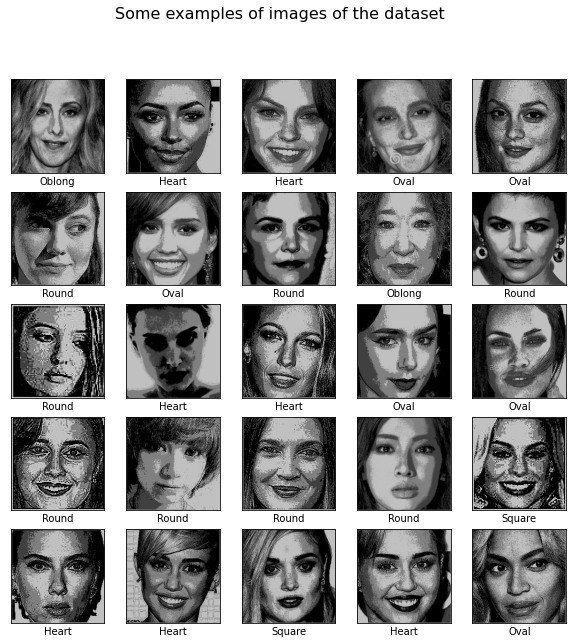

In [23]:
import cv2
import matplotlib.pyplot as plt  

def display_examples():
    
    """
        Display 25 images from the images and labels
    """
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_path = train_df.iloc[i]["path"]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(train_df.iloc[i]["label"])
    plt.show()

display_examples()

# Dataset

In [24]:
# Dataset
class FaceShapeDataset(torch.utils.data.Dataset):
    def __init__(self, df, transform=None, split="train"):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.split = split
        class_names = ['Heart', 'Oblong', 'Oval', 'Round', 'Square']
        self.label2idx = {class_name:i for i, class_name in enumerate(class_names)}
        self.idx2label = {v:k for k,v in self.label2idx.items()}
    
    def __len__(self):
        return len(self.df)

   
    def __getitem__(self, idx):
        try:
            img_path = self.df.loc[idx, "path"]
            img = Image.open(img_path).convert('L')
            if self.transform:
                img = self.transform(img)
            
            label = self.df.loc[idx, "label"]
            label = self.label2idx[label]
            return img, torch.tensor(label)
        except:
            print(f"Error load image {img_path}")
            idx = 0
            img_path = self.df.loc[idx, "path"]
            img = Image.open(img_path).convert('L')
            if self.transform:
                img = self.transform(img)
            
            label = self.df.loc[idx, "label"]
            label = self.label2idx[label]
            return img, torch.tensor(label)

        

# EfficientNet

In [25]:
# Models
class EffNet(nn.Module):
    def __init__(self, num_classes=5):
        super(EffNet, self).__init__()
        self.eff = EfficientNet.from_pretrained('efficientnet-b5', num_classes=num_classes, in_channels=1)
    def forward(self, x):
        x = self.eff(x)
        return x

# Train

In [26]:
def train(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    best_accuracy = 0
    for epoch in range(epochs):
        model.train()
        bar = tqdm(enumerate(train_loader), total=len(train_loader), desc="Training Epoch {}".format(epoch+1))
        for batch_idx, (data, target) in bar:
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            bar.set_postfix(loss=loss.item())
        
        
        model.eval()
        val_loss = 0
        correct = 0
        
        with torch.no_grad():
            bar = tqdm(enumerate(val_loader), total=len(val_loader), desc="Validation Epoch {}".format(epoch+1))
            for batch_idx, (data, target) in bar:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += F.cross_entropy(output, target, reduction='sum').item()
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(target.view_as(pred)).sum().item()
        val_loss /= len(val_loader.dataset)
        val_accuracy = 100. * correct / len(val_loader.dataset)
        print('\nValidation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
            val_loss, correct, len(val_loader.dataset),
            val_accuracy))
        
        # save best model
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            torch.save(model.state_dict(), "./best_model.pth")
            print("Saved best model")
        print("Best accuracy: {}".format(best_accuracy))

    return model

# Start training

In [27]:
# Configs
class args:
    data_dir="../Face-Shape-EfficientNetB5/imageSet/grayPoster"
    batch_size=32
    n_epochs=30
    learning_rate=0.001
    debug=False

In [32]:
train_df, val_df, test_df = split_train_val(args.data_dir)
if args.debug:
    train_df, val_df = train_df.sample(n=10).reset_index(drop=True), val_df.sample(n=10).reset_index(drop=True)

transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_loader = torch.utils.data.DataLoader(
    FaceShapeDataset(train_df, transform=transform, split="train"),
    batch_size=args.batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    FaceShapeDataset(val_df, transform=transform, split="val"),
    batch_size=args.batch_size, shuffle=False
)

import time
from datetime import timedelta
st = time.time()
print("-------- Start training --------")
model = EffNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)
model = train(model, train_loader, val_loader, criterion, optimizer, epochs=args.n_epochs, device=device)
print("-------- End training, time taken:", timedelta(seconds=int(time.time()-st)))

-------- Start training --------
Loaded pretrained weights for efficientnet-b5


Training Epoch 1:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 1:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.5951, Accuracy: 145/384 (38%)

Saved best model
Best accuracy: 37.760416666666664


Training Epoch 2:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 2:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 2.2911, Accuracy: 122/384 (32%)

Best accuracy: 37.760416666666664


Training Epoch 3:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 3:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 2.8725, Accuracy: 143/384 (37%)

Best accuracy: 37.760416666666664


Training Epoch 4:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 4:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.5704, Accuracy: 197/384 (51%)

Saved best model
Best accuracy: 51.302083333333336


Training Epoch 5:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 5:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.4551, Accuracy: 222/384 (58%)

Saved best model
Best accuracy: 57.8125


Training Epoch 6:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 6:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.4799, Accuracy: 257/384 (67%)

Saved best model
Best accuracy: 66.92708333333333


Training Epoch 7:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 7:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 0.9801, Accuracy: 280/384 (73%)

Saved best model
Best accuracy: 72.91666666666667


Training Epoch 8:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 8:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.2178, Accuracy: 273/384 (71%)

Best accuracy: 72.91666666666667


Training Epoch 9:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 9:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.1255, Accuracy: 272/384 (71%)

Best accuracy: 72.91666666666667


Training Epoch 10:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 10:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.4987, Accuracy: 258/384 (67%)

Best accuracy: 72.91666666666667


Training Epoch 11:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 11:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.2465, Accuracy: 281/384 (73%)

Saved best model
Best accuracy: 73.17708333333333


Training Epoch 12:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 12:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.1016, Accuracy: 272/384 (71%)

Best accuracy: 73.17708333333333


Training Epoch 13:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 13:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.6021, Accuracy: 239/384 (62%)

Best accuracy: 73.17708333333333


Training Epoch 14:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 14:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.2120, Accuracy: 278/384 (72%)

Best accuracy: 73.17708333333333


Training Epoch 15:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 15:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.2665, Accuracy: 270/384 (70%)

Best accuracy: 73.17708333333333


Training Epoch 16:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 16:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.1529, Accuracy: 296/384 (77%)

Saved best model
Best accuracy: 77.08333333333333


Training Epoch 17:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 17:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.8134, Accuracy: 249/384 (65%)

Best accuracy: 77.08333333333333


Training Epoch 18:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 18:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.7670, Accuracy: 256/384 (67%)

Best accuracy: 77.08333333333333


Training Epoch 19:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 19:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.0631, Accuracy: 294/384 (77%)

Best accuracy: 77.08333333333333


Training Epoch 20:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 20:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.2816, Accuracy: 284/384 (74%)

Best accuracy: 77.08333333333333


Training Epoch 21:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 21:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.9125, Accuracy: 270/384 (70%)

Best accuracy: 77.08333333333333


Training Epoch 22:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 22:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.4927, Accuracy: 261/384 (68%)

Best accuracy: 77.08333333333333


Training Epoch 23:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 23:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.0074, Accuracy: 281/384 (73%)

Best accuracy: 77.08333333333333


Training Epoch 24:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 24:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 0.8850, Accuracy: 304/384 (79%)

Saved best model
Best accuracy: 79.16666666666667


Training Epoch 25:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 25:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 0.9061, Accuracy: 297/384 (77%)

Best accuracy: 79.16666666666667


Training Epoch 26:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 26:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.2807, Accuracy: 288/384 (75%)

Best accuracy: 79.16666666666667


Training Epoch 27:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 27:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.6911, Accuracy: 262/384 (68%)

Best accuracy: 79.16666666666667


Training Epoch 28:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 28:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.1837, Accuracy: 292/384 (76%)

Best accuracy: 79.16666666666667


Training Epoch 29:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 29:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.6280, Accuracy: 275/384 (72%)

Best accuracy: 79.16666666666667


Training Epoch 30:   0%|          | 0/108 [00:00<?, ?it/s]

Validation Epoch 30:   0%|          | 0/12 [00:00<?, ?it/s]


Validation set: Average loss: 1.1588, Accuracy: 285/384 (74%)

Best accuracy: 79.16666666666667
-------- End training, time taken: 1:11:19


# Predict on Test set

In [29]:
test_ds = FaceShapeDataset(test_df, transform=transform, split="test")
test_loader = torch.utils.data.DataLoader(
    test_ds,
    batch_size=args.batch_size, shuffle=False
)

model.eval()
test_loss = 0
correct = 0
y_true = []
y_pred = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        test_loss += F.cross_entropy(output, target, reduction='sum').item()
        pred = output.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        y_true += target.view(-1).tolist()
        y_pred += pred.view(-1).tolist()
test_loss /= len(test_loader.dataset)
print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

y_true = [test_ds.idx2label[i] for i in y_true]
y_pred = [test_ds.idx2label[i] for i in y_pred]
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


Test set: Average loss: 1.0332, Accuracy: 744/956 (78%)

              precision    recall  f1-score   support

       Heart       0.78      0.68      0.72       197
      Oblong       0.85      0.86      0.86       189
        Oval       0.71      0.74      0.72       189
       Round       0.79      0.73      0.76       188
      Square       0.77      0.89      0.83       193

    accuracy                           0.78       956
   macro avg       0.78      0.78      0.78       956
weighted avg       0.78      0.78      0.78       956



# Confusion matrix

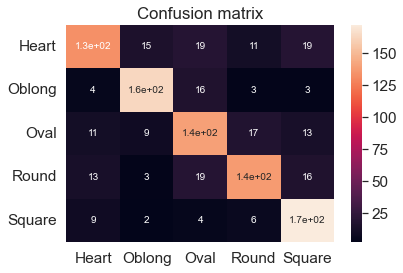

In [30]:
from sklearn.metrics import confusion_matrix
import seaborn as sn; sn.set(font_scale=1.4)

CM = confusion_matrix(y_true, y_pred)
class_names = list(test_ds.label2idx.keys())
ax = plt.axes()
sn.heatmap(CM, annot=True, 
           annot_kws={"size": 10}, 
           xticklabels=class_names, 
           yticklabels=class_names, ax = ax)
ax.set_title('Confusion matrix')
plt.show()

# Visualize some predicted results

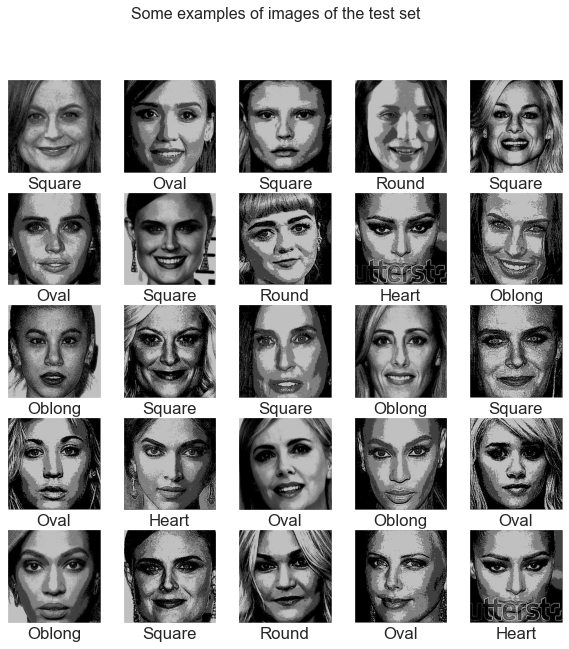

In [31]:
import cv2
import matplotlib.pyplot as plt
from random import randint

list_idx = [randint(0, len(test_ds)) for i in range(25)]

def display_examples():
    
    """
        Display 25 images from the images and labels
    """
    fig = plt.figure(figsize=(10,10))
    fig.suptitle("Some examples of images of the test set", fontsize=16)
    for i,idx in enumerate(list_idx):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        img_path = test_ds.df.iloc[idx]["path"]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        plt.imshow(image, cmap=plt.cm.binary)
        plt.xlabel(y_true[idx])
    plt.show()

display_examples()